# Imports and Setup

In [449]:
import sys
assert sys.version_info >= (3, 5)

import numpy as np
import pandas as pd
import statistics as stat
import random
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import optproblems.cec2005 as opt
import optproblems.base as base

# Helper Functions

In [450]:
# Evaluate a solution on a function using the optproblems library
def eval(func, position):
    pos = base.Individual(position)
    func.evaluate(pos)
    return pos.objective_values

# Particle Swarm Optimisation Algorithm

### Particle Class

In [451]:
class Particle:
    def __init__(self, numInputs, domain, func, weights, boundary):
        # Particle Attributes
        self.position = []
        self.velocity = []
        self.informants: list[Particle] = []

        # More Attributes for the implementation
        self.bestPos = []
        self.func = func
        self.domain = domain
        self.dimensions = numInputs
        self.weights = weights
        self.boundary = boundary

        # Initialising position randomly within domain of the problem
        # Initialising velocity randomly to +/-10% of the size of the search space
        for i in range(numInputs):
            self.position.append(random.uniform(domain[0], domain[1]))
            self.velocity.append(random.uniform(-np.abs(domain[1] - domain[0])/10, np.abs(domain[1] - domain[0])/10))

        # Initialising result and best result/position
        self.result = eval(func, self.position)
        self.bestResult = self.result
        self.bestPos = self.position.copy()
    
    # Evaluate the current position/solution of the particle
    def evaluate(self):
        self.result = eval(self.func, self.position)

        # Update best position if new position is better
        if self.result < self.bestResult:
            self.bestResult = self.result
            self.bestPos = self.position.copy()

    # Update the velocity of the particle
    def update_velocity(self, globalBestPos):
        # Identifying the best informant
        bestInformant = self.informants[0]
        for particle in self.informants:
            if particle.bestResult < bestInformant.bestResult:
                bestInformant = particle

        # For every dimension calculate each aspect of the new velocity and update
        for i in range(self.dimensions):
            # Cognitive: The particle's own best position (with a random weight in a range)
            cognitive = random.uniform(0, self.weights[1])*(self.bestPos[i] - self.position[i])

            # Social: The particle's informants' best position (with a random weight in a range)
            social = random.uniform(0, self.weights[2])*(bestInformant.bestPos[i] - self.position[i])

            # Global: The swarm's best position (with a random weight in a range)
            globalv = random.uniform(0, self.weights[3])*(globalBestPos[i] - self.position[i])

            # Add all the aspects together with the particles inertia as the new velocity
            self.velocity[i] = self.weights[0]*self.velocity[i] + cognitive + social + globalv
    
    # Update the particles position
    def update_position(self):
        # For each dimension, add the dimenions velocity multiplied with the step size
        for i in range(self.dimensions):
            self.position[i] += self.weights[4] * self.velocity[i]
            
            # If the function has a boundary, keep the particle within the boundary
            if self.boundary:
                if self.position[i] < self.domain[0]:
                    self.position[i] = self.domain[0]
                elif self.position[i] > self.domain[1]:
                    self.position[i] = self.domain[1]

### Particle Swarm Optimization Algorithm Class

In [452]:
class PSO():
    def __init__(self, numInputs, domain, func, weights, swarmSize, numInformants, maxIter, boundary = True):
        # PSO Attributes
        self.swarm: list[Particle] = []
        self.swarmSize = swarmSize
        self.maxIter = maxIter

        # More Attributes for the implementation
        self.domain = domain
        self.func = func
        self.numInputs = numInputs

        # Initial swarm for display purposes
        self.initSwarm = []

        # Create swarm
        for i in range(swarmSize):
            particle = Particle(numInputs, domain, func, weights, boundary)
            self.swarm.append(particle)
            # Initial swarm position for display purposes
            self.initSwarm.append(particle.position.copy())
        
        # Give each particle a list of random informants (Not including itself and duplicates as informants)
        for i in range(swarmSize):
            while len(self.swarm[i].informants) < numInformants:
                inform = random.choice(self.swarm)
                if self.swarm[i].informants.__contains__(inform) or self.swarm[i] == inform:
                    continue
                else:
                    self.swarm[i].informants.append(inform)

        self.globalBest = self.swarm[0]

    # Optimisation loop
    def optimize(self):
        # Loop until max number of iterations reached
        i = 0
        while i < self.maxIter:
            # Evaluate all particles
            for j in range(self.swarmSize):
                self.swarm[j].evaluate()
            
            # Find global best
            for j in range(self.swarmSize):
                if self.swarm[j].bestResult < self.globalBest.bestResult:
                    self.globalBest = self.swarm[j]

            # Update all particles velocities and positions
            for j in range(self.swarmSize):
                self.swarm[j].update_velocity(self.globalBest.bestPos)
                self.swarm[j].update_position()

            i+=1

    # Simply prints the solution and result
    def print_result(self):
        print("Solution:")
        print(self.globalBest.bestPos)
        print("Result:")
        print(self.globalBest.bestResult)

    # FOR 2 DIMENSION PROBLEMS ONLY WITH INTEGER BOUNDARIES
    # Displays a graph of the problem with useful information on it like:
    # Initial swarm positions, final swarm positions, best result of swarm, and actual best result of the problem
    def display_graph(self):
        # Error Catching
        if self.numInputs != 2:
            print("Display is only possible with 2 dimensions/number of inputs!")
            return
        elif type(self.domain[0]) != int or type(self.domain[1]) != int:
            print("Can't display non integer bounds!")
            return

        boundT = 2*self.domain[1] 
        x, y = np.array(np.meshgrid(np.linspace(-self.domain[1],self.domain[1],boundT), np.linspace(-self.domain[1],self.domain[1],boundT)))
        z = np.zeros([boundT, boundT])

        for i in range(boundT):
            for j in range(boundT):
                plotSoln = base.Individual(np.array([x[i][j], y[i][j]]))
                self.func.evaluate(plotSoln)
                z[i][j] = plotSoln.objective_values

        xFirst = np.zeros(self.swarmSize)                                          
        yFirst = np.zeros(self.swarmSize)
        xFinal = np.zeros(self.swarmSize) 
        yFinal = np.zeros(self.swarmSize)

        for i in range(self.swarmSize):
            xFirst[i] = self.initSwarm[i][0]
            yFirst[i] = self.initSwarm[i][1]

        for i in range(self.swarmSize):
            xFinal[i] = self.swarm[i].position[0]
            yFinal[i] = self.swarm[i].position[1]

        x_min = x.reshape(-1)[z.argmin()]
        y_min = y.reshape(-1)[z.argmin()]

        # Plotting all different aspects of the graph
        plt.figure(figsize=(6,4))
        plt.imshow(z, extent=[-self.domain[1], self.domain[1], -self.domain[1], self.domain[1]], origin='lower', cmap='PuBuGn', alpha=1)
        plt.colorbar()
        plt.plot([x_min], [y_min], marker='x', markersize=10, color="black", label="Optimal")
        plt.plot(self.globalBest.bestPos[0], self.globalBest.bestPos[1], marker='^', markersize=5, color="black", label="Best")
        contours = plt.contour(x, y, z, colors='black', alpha=0.4)
        plt.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
        plt.scatter(xFirst, yFirst, 5, c="orange", label="first generation") 
        plt.scatter(xFinal, yFinal, 5, c="red", label="last generation")
        plt.legend()
        plt.show()


# Hyperparameters:

In [453]:
# Problem Parameters
Number_of_Inputs = 2
Func_Domain = [-100, 100]
Stay_Within_Bounds = True
Function = opt.F1(Number_of_Inputs)

# Simple Hyperparameters
Swarm_Size = 100
Number_of_Informants = 10
Max_Number_of_Iterations = 100

# Weights Hyperparameters
Inertia = 0.5
Personal_Best = 0.5
Informants_Best = 0.5
Global_Best = 0.5
Jump_Size = 1
Weights = [Inertia, Personal_Best, Informants_Best, Global_Best, Jump_Size]

# Runnning and Testing

Solution:
[-39.31189993843238, 58.89989989525651]
Result:
-450.0


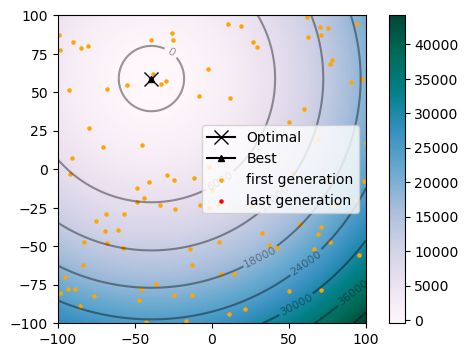

[-39.3119, 58.8999]


In [454]:
# Running PSO
pso = PSO(Number_of_Inputs, Func_Domain, Function, Weights, Swarm_Size, Number_of_Informants, Max_Number_of_Iterations, Stay_Within_Bounds)
pso.optimize()
pso.print_result()
pso.display_graph()

# Displaying actual optimal solution
optSol = Function.get_optimal_solutions()[0]
Function.evaluate(optSol)
print(optSol.phenome)

# Testing with Performance Metrics

In [455]:
def run(runs): 
    # Get actual optimal solution
    optSol = Function.get_optimal_solutions()[0]
    Function.evaluate(optSol)

    # Running n number of times and recording best particle
    bestParticleList : list[Particle] = []
    for i in range(runs):
      pso = PSO(Number_of_Inputs, Func_Domain, Function, Weights, Swarm_Size, Number_of_Informants, Max_Number_of_Iterations, Stay_Within_Bounds)
      pso.optimize()
      bestParticleList.append(pso.globalBest)

    # Recording average, percent error, and standard deviation of all n runs
    avgSum = 0
    blob = []
    for i in range(runs):
      blob.append(bestParticleList[i].bestResult)
      avgSum += bestParticleList[i].bestResult
    averageObjVal = sum(blob)/len(blob)
    print("Actual =", optSol.objective_values)
    print("Average =", averageObjVal)
    accuracy = abs((optSol.objective_values - averageObjVal)/optSol.objective_values) * 100
    print("Percenatge error of value = ", accuracy)
    stdDevObjVal = stat.pstdev(blob)
    print("The Standard Deviation of best value of the past 10 runs is ", stdDevObjVal)

    # Calculating average percent error and standard deviation of all particles in the last run
    stdSum = []
    stdAvg = np.zeros(Number_of_Inputs)
    stdAcc = []
    resStdDev = []
    for i in range(Number_of_Inputs):
      stdSum = []
      for j in range(runs):
        stdSum.append(bestParticleList[j].bestPos[i])
      stdAvg[i] = sum(stdSum)/len(stdSum)
      stdAcc.append(abs((optSol.phenome[i] - stdAvg[i])/optSol.phenome[i]) * 100)
      resStdDev.append(stat.pstdev(stdSum))
    perErr = sum(stdAcc)/len(stdAcc)             
    print("Avg percentage error for elements of solution is ", perErr)
    avgStdDev = sum(resStdDev)/len(resStdDev)
    print("Avg standard deviation for elements of solution is ", avgStdDev)

In [456]:
run(10)

Actual = -450.0
Average = -450.0
Percenatge error of value =  0.0
The Standard Deviation of best value of the past 10 runs is  0.0
Avg percentage error for elements of solution is  6.743282294678379e-08
Avg standard deviation for elements of solution is  7.417484999682903e-08
